In [1]:
import os
import glob
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from Levenshtein import distance as levenshtein_distance

# --- –£—Å—Ç–∞–Ω–æ–≤–∫–∞ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö –±–∏–±–ª–∏–æ—Ç–µ–∫ (–µ—Å–ª–∏ –Ω—É–∂–Ω–æ) ---
# !pip install Pillow tqdm torch torchvision scikit-learn seaborn python-Levenshtein -q

# --- –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –∏ –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç–∏ CUDA ---
print("--- –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–∏—Å—Ç–µ–º—ã ---")
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"‚úÖ CUDA –¥–æ—Å—Ç—É–ø–Ω–∞. –ë—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω GPU: {gpu_name}")
else:
    device = torch.device("cpu")
    print("‚ö†Ô∏è CUDA –Ω–µ –Ω–∞–π–¥–µ–Ω–∞. –û–±—É—á–µ–Ω–∏–µ –±—É–¥–µ—Ç –ø—Ä–æ–∏—Å—Ö–æ–¥–∏—Ç—å –Ω–∞ CPU.")
print("---------------------\n")

--- –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–∏—Å—Ç–µ–º—ã ---
‚úÖ CUDA –¥–æ—Å—Ç—É–ø–Ω–∞. –ë—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω GPU: NVIDIA GeForce RTX 3070 Ti
---------------------



In [2]:
# --- –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö ---
DATASET_BASE_PATH = 'E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/' 
TRAIN_DIR = os.path.join(DATASET_BASE_PATH, 'train')
VAL_DIR = os.path.join(DATASET_BASE_PATH, 'val')

# --- –°–±–æ—Ä –∞–ª—Ñ–∞–≤–∏—Ç–∞ ---
all_chars = set()
print("–°–æ–±–∏—Ä–∞—é –∞–ª—Ñ–∞–≤–∏—Ç –∏–∑ –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏...")

train_ann_dir = os.path.join(TRAIN_DIR, 'ann')
train_files = glob.glob(os.path.join(train_ann_dir, '*.json'))

for ann_path in tqdm(train_files):
    with open(ann_path, 'r', encoding='utf-8') as f:
        ann = json.load(f)
        # –í —ç—Ç–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ —Ç–µ–∫—Å—Ç –Ω–æ–º–µ—Ä–∞ –ª–µ–∂–∏—Ç –≤ –ø–æ–ª–µ 'description'
        plate_text = ann.get('description', '')
        for char in plate_text:
            all_chars.add(char)

# --- –°–æ–∑–¥–∞–Ω–∏–µ —Å–ª–æ–≤–∞—Ä–µ–π –∏ –∫–æ–Ω—Å—Ç–∞–Ω—Ç ---
alphabet = sorted(list(all_chars))
ALPHABET = ''.join(alphabet)
print(f"‚úÖ –ê–ª—Ñ–∞–≤–∏—Ç —Å–æ–±—Ä–∞–Ω: '{ALPHABET}' (–î–ª–∏–Ω–∞: {len(ALPHABET)})")

# +1 –¥–ª—è 'blank' —Ç–æ–∫–µ–Ω–∞ CTC
NUM_CLASSES = len(ALPHABET) + 1 
IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 64

# --- –°–ª–æ–≤–∞—Ä–∏ –¥–ª—è –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è/–¥–µ–∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è ---
char_to_int = {char: i + 1 for i, char in enumerate(ALPHABET)}
int_to_char = {i: char for char, i in char_to_int.items()}

–°–æ–±–∏—Ä–∞—é –∞–ª—Ñ–∞–≤–∏—Ç –∏–∑ –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏...


  0%|          | 0/49382 [00:00<?, ?it/s]

‚úÖ –ê–ª—Ñ–∞–≤–∏—Ç —Å–æ–±—Ä–∞–Ω: '0123456789ABCEHKMOPTXY' (–î–ª–∏–Ω–∞: 22)


In [3]:
class OCRDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.img_dir = os.path.join(base_dir, 'img')
        self.ann_dir = os.path.join(base_dir, 'ann')
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(self.img_dir)]
        print(f"–ù–∞–π–¥–µ–Ω–æ {len(self.filenames)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ {base_dir}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.img_dir, filename + '.png') 
        ann_path = os.path.join(self.ann_dir, filename + '.json')
        
        try:
            image = Image.open(img_path).convert('L')
            with open(ann_path, 'r', encoding='utf-8') as f:
                ann = json.load(f)
                text = ann.get('description', '')
            if self.transform:
                image = self.transform(image)
            return image, text
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self))

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = OCRDataset(TRAIN_DIR, transform=transform)
val_dataset = OCRDataset(VAL_DIR, transform=transform)

def collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images, 0)
    encoded_texts = [torch.tensor([char_to_int.get(char, 0) for char in text]) for text in texts]
    text_lengths = torch.tensor([len(text) for text in encoded_texts])
    encoded_texts = nn.utils.rnn.pad_sequence(encoded_texts, batch_first=True)
    return images, encoded_texts, text_lengths

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)

print("\n‚úÖ –î–∞—Ç–∞–ª–æ–∞–¥–µ—Ä—ã –≥–æ—Ç–æ–≤—ã.")

–ù–∞–π–¥–µ–Ω–æ 49382 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/train
–ù–∞–π–¥–µ–Ω–æ 4893 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/val

‚úÖ –î–∞—Ç–∞–ª–æ–∞–¥–µ—Ä—ã –≥–æ—Ç–æ–≤—ã.


In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        
        # --- CNN —á–∞—Å—Ç—å (–ì–ª–∞–∑–∞) ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d(2, 2), # -> height: 16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d(2, 2), # -> height: 8
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d((2, 1), (2, 1)), # -> height: 4
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d((2, 1), (2, 1)) # -> height: 2. 
        
        # --- RNN —á–∞—Å—Ç—å (–ú–æ–∑–≥) ---
        
        self.rnn = nn.LSTM(512 * 2, 256, bidirectional=True, num_layers=2, batch_first=True)
        
        # --- Classifier (–†–æ—Ç) ---
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # –ü—Ä–æ–≥–æ–Ω—è–µ–º —á–µ—Ä–µ–∑ CNN
        x = self.cnn(x) # -> (batch, 512, 2, 32)
        
        
        # "–†–∞—Å–ø—Ä—è–º–ª—è–µ–º" –≤—ã—Ö–æ–¥ CNN –¥–ª—è –ø–æ–¥–∞—á–∏ –≤ RNN
        # –æ–±—ä–µ–¥–∏–Ω—è–µ–º –∫–∞–Ω–∞–ª—ã –∏ –≤—ã—Å–æ—Ç—É
        batch, channels, height, width = x.size()
        x = x.reshape(batch, channels * height, width) 
        
        # –ú–µ–Ω—è–µ–º –æ—Å–∏ –º–µ—Å—Ç–∞–º–∏ –¥–ª—è RNN, –∫–æ—Ç–æ—Ä—ã–π –æ–∂–∏–¥–∞–µ—Ç (batch, seq_len, features)
        x = x.permute(0, 2, 1) # -> (batch, 32, 1024)
        
        # –ü—Ä–æ–≥–æ–Ω—è–µ–º —á–µ—Ä–µ–∑ RNN
        x, _ = self.rnn(x) # -> (batch, 32, 512)
        
        # –ü—Ä–æ–≥–æ–Ω—è–µ–º —á–µ—Ä–µ–∑ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä
        x = self.classifier(x) # -> (batch, 32, num_classes)
        
        # –î–ª—è CTCLoss –Ω–∞–º –Ω—É–∂–µ–Ω —Ñ–æ—Ä–º–∞—Ç (sequence_length, batch, num_classes)
        x = x.permute(1, 0, 2) # -> (32, batch, num_classes)
        x = nn.functional.log_softmax(x, dim=2)
        
        return x

print("–ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –º–æ–¥–µ–ª–∏ CRNN.")

–ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –º–æ–¥–µ–ª–∏ CRNN.


In [5]:
model = CRNN(NUM_CLASSES).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def decode_preds(preds):
    preds = preds.permute(1, 0, 2)
    preds = torch.argmax(preds, dim=2)
    decoded_texts = []
    for pred in preds:
        decoded_seq = []
        last_char_idx = 0
        for char_idx in pred:
            char_idx = char_idx.item()
            if char_idx != 0 and char_idx != last_char_idx:
                decoded_seq.append(int_to_char.get(char_idx, ''))
            last_char_idx = char_idx
        decoded_texts.append("".join(decoded_seq))
    return decoded_texts

def calculate_cer(preds, targets):
    total_dist, total_len = 0, 0
    for pred, target in zip(preds, targets):
        total_dist += levenshtein_distance(pred, target)
        total_len += len(target)
    return total_dist / total_len if total_len > 0 else 0

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_cer': []}
best_val_accuracy = 0.0
NUM_EPOCHS = 30

print(f"\nüöÄ –ù–∞—á–∏–Ω–∞—é –æ–±—É—á–µ–Ω–∏–µ –Ω–∞ {NUM_EPOCHS} —ç–ø–æ—Ö...")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, texts, text_lengths in progress_bar:
        images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
        optimizer.zero_grad()
        preds = model(images)
        pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
        loss = criterion(preds, texts, pred_lengths, text_lengths)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    all_decoded_preds, all_original_texts = [], []
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for images, texts, text_lengths in progress_bar_val:
            images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
            preds = model(images)
            pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
            val_loss += criterion(preds, texts, pred_lengths, text_lengths).item()
            decoded_preds = decode_preds(preds)
            original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
            all_decoded_preds.extend(decoded_preds)
            all_original_texts.extend(original_texts)
            
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = sum(1 for pred, orig in zip(all_decoded_preds, all_original_texts) if pred == orig) / len(all_original_texts)
    val_cer = calculate_cer(all_decoded_preds, all_original_texts)
    
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_cer'].append(val_cer)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val CER: {val_cer:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'crnn_ocr_model_best.pth')
        print(f"‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: {best_val_accuracy:.4f}")



üöÄ –ù–∞—á–∏–Ω–∞—é –æ–±—É—á–µ–Ω–∏–µ –Ω–∞ 30 —ç–ø–æ—Ö...


Epoch 1/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 2.7078 | Val Loss: 1.4953 | Val Acc: 0.0006 | Val CER: 0.5545
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.0006


Epoch 2/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.2753 | Val Loss: 0.0276 | Val Acc: 0.9618 | Val CER: 0.0050
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.9618


Epoch 3/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.0210 | Val Loss: 0.0108 | Val Acc: 0.9869 | Val CER: 0.0017
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.9869


Epoch 4/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.0129 | Val Loss: 0.0139 | Val Acc: 0.9777 | Val CER: 0.0028


Epoch 5/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.0091 | Val Loss: 0.0066 | Val Acc: 0.9896 | Val CER: 0.0013
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.9896


Epoch 6/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.0057 | Val Loss: 0.0077 | Val Acc: 0.9855 | Val CER: 0.0020


Epoch 7/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.0082 | Val Loss: 0.0060 | Val Acc: 0.9910 | Val CER: 0.0011
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.9910


Epoch 8/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.0054 | Val Loss: 0.0048 | Val Acc: 0.9933 | Val CER: 0.0008
‚ú® –ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ —Å —Ç–æ—á–Ω–æ—Å—Ç—å—é: 0.9933


Epoch 9/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

KeyboardInterrupt: 

--- üìä –ì—Ä–∞—Ñ–∏–∫–∏ –ø—Ä–æ—Ü–µ—Å—Å–∞ –æ–±—É—á–µ–Ω–∏—è ---


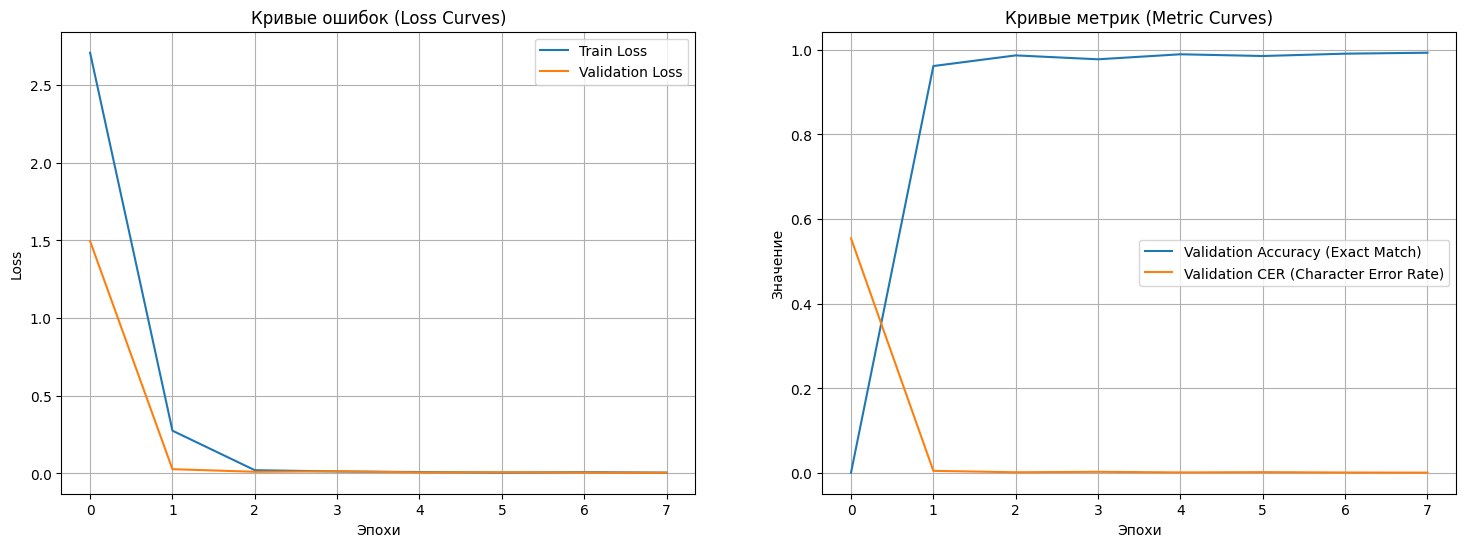


---  Confusion Matrix (–Ω–∞ —É—Ä–æ–≤–Ω–µ —Å–∏–º–≤–æ–ª–æ–≤) ---


–°–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –º–∞—Ç—Ä–∏—Ü—ã –æ—à–∏–±–æ–∫:   0%|          | 0/77 [00:00<?, ?it/s]

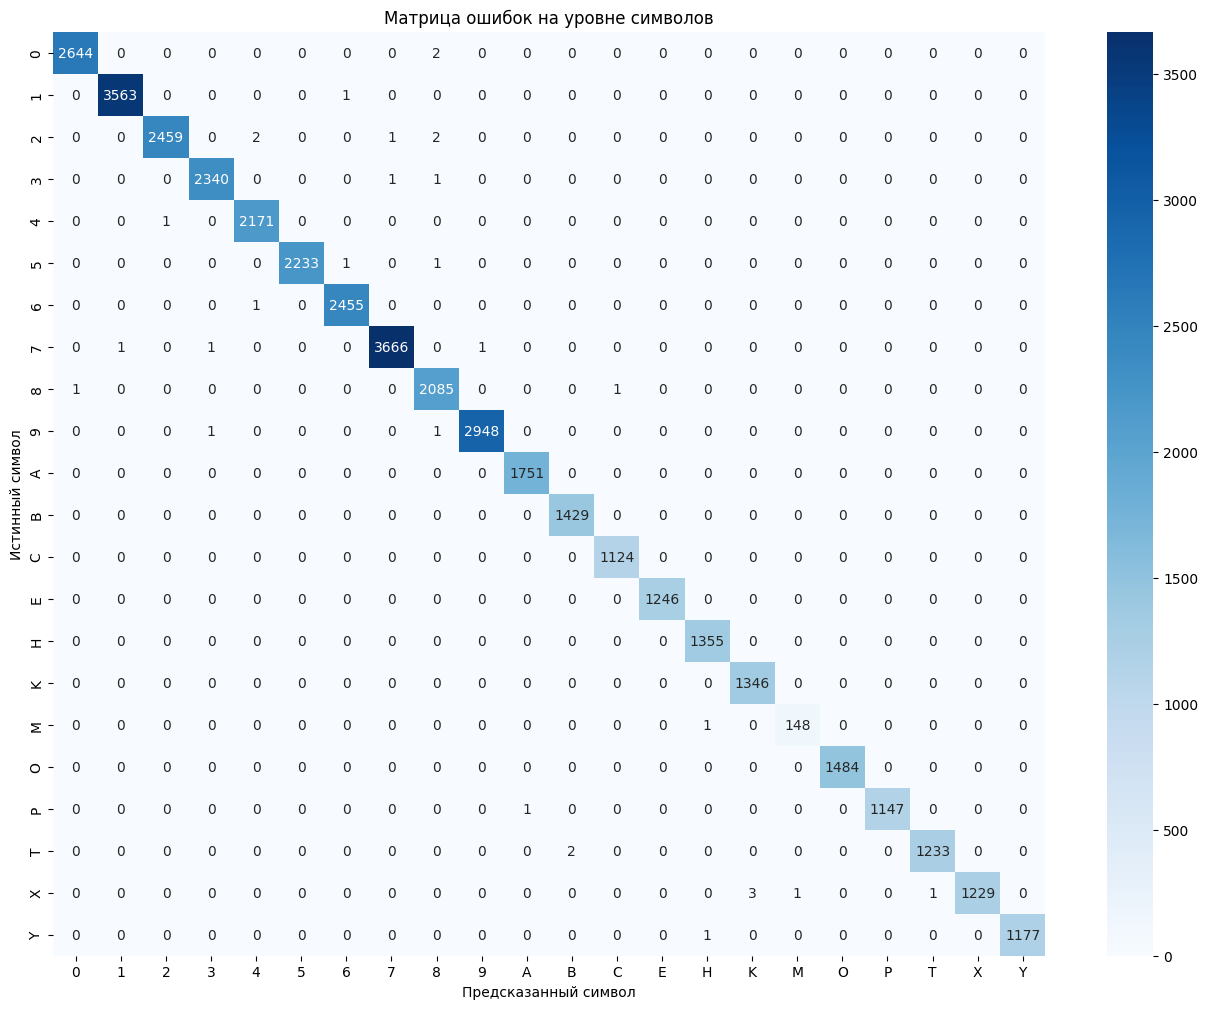


--- üèÜ –§–∏–Ω–∞–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ ---
–õ—É—á—à–∞—è —ç–ø–æ—Ö–∞: 8
–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): 0.9933
–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): 0.0008
------------------------------------------



In [6]:
print("--- üìä –ì—Ä–∞—Ñ–∏–∫–∏ –ø—Ä–æ—Ü–µ—Å—Å–∞ –æ–±—É—á–µ–Ω–∏—è ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('–ö—Ä–∏–≤—ã–µ –æ—à–∏–±–æ–∫ (Loss Curves)')
axes[0].set_xlabel('–≠–ø–æ—Ö–∏'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)
axes[1].plot(history['val_accuracy'], label='Validation Accuracy (Exact Match)')
axes[1].plot(history['val_cer'], label='Validation CER (Character Error Rate)')
axes[1].set_title('–ö—Ä–∏–≤—ã–µ –º–µ—Ç—Ä–∏–∫ (Metric Curves)'); axes[1].set_xlabel('–≠–ø–æ—Ö–∏')
axes[1].set_ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ'); axes[1].legend(); axes[1].grid(True)
plt.show()

print("\n---  Confusion Matrix (–Ω–∞ —É—Ä–æ–≤–Ω–µ —Å–∏–º–≤–æ–ª–æ–≤) ---")
model.load_state_dict(torch.load('crnn_ocr_model_best.pth'))
model.eval()
all_true_chars, all_pred_chars = [], []
with torch.no_grad():
    for images, texts, text_lengths in tqdm(val_loader, desc="–°–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –º–∞—Ç—Ä–∏—Ü—ã –æ—à–∏–±–æ–∫"):
        images = images.to(device)
        preds = model(images)
        decoded_preds = decode_preds(preds)
        original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
        for true_str, pred_str in zip(original_texts, decoded_preds):
            for i in range(min(len(true_str), len(pred_str))):
                all_true_chars.append(true_str[i])
                all_pred_chars.append(pred_str[i])

labels = sorted(list(ALPHABET))
cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('–ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫ –Ω–∞ —É—Ä–æ–≤–Ω–µ —Å–∏–º–≤–æ–ª–æ–≤'); plt.ylabel('–ò—Å—Ç–∏–Ω–Ω—ã–π —Å–∏–º–≤–æ–ª'); plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π —Å–∏–º–≤–æ–ª')
plt.show()

print("\n--- üèÜ –§–∏–Ω–∞–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ ---")
best_epoch_idx = np.argmax(history['val_accuracy'])
print(f"–õ—É—á—à–∞—è —ç–ø–æ—Ö–∞: {best_epoch_idx + 1}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): {history['val_accuracy'][best_epoch_idx]:.4f}")
print(f"–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): {history['val_cer'][best_epoch_idx]:.4f}")
print("------------------------------------------\n")

–ù–∞–π–¥–µ–Ω–æ 2845 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/test

‚úÖ –¢–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö –≥–æ—Ç–æ–≤. –ù–∞–π–¥–µ–Ω–æ 2845 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π.
üöÄ –ù–∞—á–∏–Ω–∞—é —Ñ–∏–Ω–∞–ª—å–Ω—É—é –æ—Ü–µ–Ω–∫—É –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ...


[Final Test]:   0%|          | 0/45 [00:00<?, ?it/s]


--- üéì –†–ï–ó–£–õ–¨–¢–ê–¢–´ –§–ò–ù–ê–õ–¨–ù–û–ì–û –≠–ö–ó–ê–ú–ï–ù–ê ---
–ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ (Test Loss): 0.0100
–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): 0.9842
–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): 0.0022
------------------------------------------

--- üñºÔ∏è –ü—Ä–∏–º–µ—Ä—ã —Ä–∞—Å–ø–æ–∑–Ω–∞–≤–∞–Ω–∏—è –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö ---


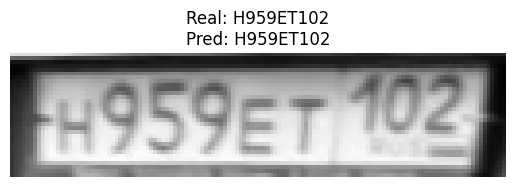

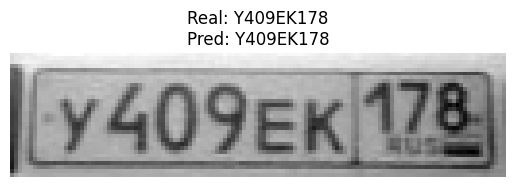

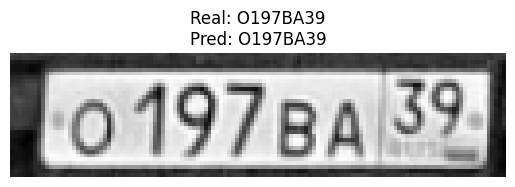

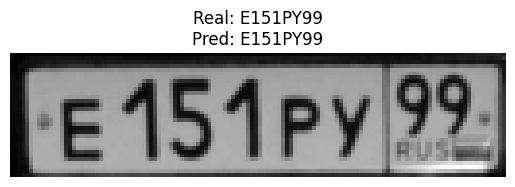

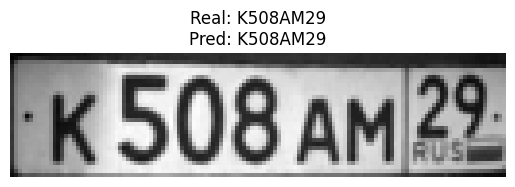

In [7]:
# --- –°–æ–∑–¥–∞–µ–º –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ ---
TEST_DIR = os.path.join(DATASET_BASE_PATH, 'test')
test_dataset = OCRDataset(TEST_DIR, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"\n‚úÖ –¢–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö –≥–æ—Ç–æ–≤. –ù–∞–π–¥–µ–Ω–æ {len(test_dataset)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π.")

# --- –ó–∞–≥—Ä—É–∂–∞–µ–º –Ω–∞—à—É –ª—É—á—à—É—é –º–æ–¥–µ–ª—å ---
model.load_state_dict(torch.load('crnn_ocr_model_best.pth'))
model.to(device)
model.eval()

# --- –ü—Ä–æ–≤–æ–¥–∏–º –æ—Ü–µ–Ω–∫—É –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ ---
print("üöÄ –ù–∞—á–∏–Ω–∞—é —Ñ–∏–Ω–∞–ª—å–Ω—É—é –æ—Ü–µ–Ω–∫—É –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ...")

test_loss = 0
all_test_decoded_preds = []
all_test_original_texts = []

with torch.no_grad():
    progress_bar_test = tqdm(test_loader, desc="[Final Test]")
    for images, texts, text_lengths in progress_bar_test:
        images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
        preds = model(images)
        pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
        
        test_loss += criterion(preds, texts, pred_lengths, text_lengths).item()
        
        decoded_preds = decode_preds(preds)
        original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
        all_test_decoded_preds.extend(decoded_preds)
        all_test_original_texts.extend(original_texts)

# --- –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –∏ –≤—ã–≤–æ–¥–∏–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ ---
avg_test_loss = test_loss / len(test_loader)
test_accuracy = sum(1 for pred, orig in zip(all_test_decoded_preds, all_test_original_texts) if pred == orig) / len(all_test_original_texts)
test_cer = calculate_cer(all_test_decoded_preds, all_test_original_texts)

print("\n--- üéì –†–ï–ó–£–õ–¨–¢–ê–¢–´ –§–ò–ù–ê–õ–¨–ù–û–ì–û –≠–ö–ó–ê–ú–ï–ù–ê ---")
print(f"–ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ (Test Loss): {avg_test_loss:.4f}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): {test_accuracy:.4f}")
print(f"–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): {test_cer:.4f}")
print("------------------------------------------\n")

# --- –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö –ø—Ä–∏–º–µ—Ä–æ–≤ –∏–∑ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ ---
print("--- üñºÔ∏è –ü—Ä–∏–º–µ—Ä—ã —Ä–∞—Å–ø–æ–∑–Ω–∞–≤–∞–Ω–∏—è –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö ---")
num_examples = 5
for i in range(num_examples):
    # –ë–µ—Ä–µ–º —Å–ª—É—á–∞–π–Ω—ã–π –∏–Ω–¥–µ–∫—Å
    idx = random.randint(0, len(all_test_decoded_preds) - 1)
    
    # –ù–∞—Ö–æ–¥–∏–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ
    img_obj, _ = test_dataset[idx]
    image = img_obj.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5 
    
    original_text = all_test_original_texts[idx]
    predicted_text = all_test_decoded_preds[idx]
    
    plt.imshow(image, cmap='gray')
    plt.title(f'Real: {original_text}\nPred: {predicted_text}')
    plt.axis('off')
    plt.show()

# –ö–≤–∞–Ω—Ç–∏–∑–∞—Ü–∏—è –∏ –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è

In [8]:
import torch
import torch.ao.quantization.quantize_fx as quantize_fx
from torch.ao.quantization import QConfigMapping
import time

print("--- üöÄ –≠—Ç–∞–ø 2.5: –ö–≤–∞–Ω—Ç–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ (FX Graph Mode) ---")

# --- 8.1. –ó–∞–≥—Ä—É–∑–∫–∞ FP32 –º–æ–¥–µ–ª–∏ ---
device_cpu = torch.device("cpu")
model_fp32 = CRNN(NUM_CLASSES)
model_fp32.load_state_dict(torch.load('crnn_ocr_model_best.pth', map_location=device_cpu))
model_fp32.eval()

print("‚úÖ FP32 –º–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞ –Ω–∞ CPU.")

# --- 8.2. –ù–∞—Å—Ç—Ä–æ–π–∫–∞ FX Graph –∫–≤–∞–Ω—Ç–∏–∑–∞—Ü–∏–∏ ---
# QConfigMapping –ø–æ–∑–≤–æ–ª—è–µ—Ç –Ω–∞—Å—Ç—Ä–æ–∏—Ç—å, –∫–∞–∫ –∫–≤–∞–Ω—Ç–æ–≤–∞—Ç—å —Ä–∞–∑–Ω—ã–µ —Ç–∏–ø—ã —Å–ª–æ–µ–≤
qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.get_default_qconfig('fbgemm'))

# --- 8.3. –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∏ –∫–∞–ª–∏–±—Ä–æ–≤–∫–∞ ---
# –°–æ–∑–¥–∞–µ–º –∫–æ–ø–∏—é –º–æ–¥–µ–ª–∏ –¥–ª—è –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∏
model_to_quantize = CRNN(NUM_CLASSES)
model_to_quantize.load_state_dict(model_fp32.state_dict())
model_to_quantize.eval()

print("\nüìä –ù–∞—á–∏–Ω–∞—é –ø–æ–¥–≥–æ—Ç–æ–≤–∫—É –∏ –∫–∞–ª–∏–±—Ä–æ–≤–∫—É (FX Graph)...")
# 'prepare_fx' –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç –º–æ–¥–µ–ª—å –∏ —Ä–∞—Å—Å—Ç–∞–≤–ª—è–µ—Ç "–Ω–∞–±–ª—é–¥–∞—Ç–µ–ª–µ–π"
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs=(torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH),))

# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ (–ø—Ä–æ–≥–æ–Ω—è–µ–º –¥–∞–Ω–Ω—ã–µ)
with torch.no_grad():
    for i, (images, _, _) in enumerate(tqdm(val_loader, desc="–ö–∞–ª–∏–±—Ä–æ–≤–∫–∞")):
        model_prepared(images)
        if i >= 20: # –î–æ—Å—Ç–∞—Ç–æ—á–Ω–æ 20 –±–∞—Ç—á–µ–π
            break
print("‚úÖ –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –∑–∞–≤–µ—Ä—à–µ–Ω–∞.")

# --- 8.4. –ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –≤ INT8 ---
model_quantized = quantize_fx.convert_fx(model_prepared)
print("\nüéâ –ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∫–≤–∞–Ω—Ç–æ–≤–∞–Ω–∞ –≤ INT8!")

# --- 8.5. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ ---
# –≠—Ç–æ—Ç —Ä–µ–∂–∏–º –Ω–µ –≤—Å–µ–≥–¥–∞ —Ö–æ—Ä–æ—à–æ —Ä–∞–±–æ—Ç–∞–µ—Ç —Å torch.jit.script, –ø–æ—ç—Ç–æ–º—É —Å–æ—Ö—Ä–∞–Ω–∏–º –ø—Ä–æ—Å—Ç–æ state_dict
# –î–ª—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞ –Ω—É–∂–Ω–æ –±—É–¥–µ—Ç —Å–æ–∑–¥–∞–≤–∞—Ç—å –º–æ–¥–µ–ª—å –∏ –∑–∞–≥—Ä—É–∂–∞—Ç—å –≤ –Ω–µ–µ —ç—Ç–∏ –≤–µ—Å–∞.
torch.save(model_quantized.state_dict(), 'crnn_ocr_model_int8_fx.pth')
print(f"‚úÖ –ö–≤–∞–Ω—Ç–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –∫–∞–∫ 'crnn_ocr_model_int8_fx.pth'")

--- üöÄ –≠—Ç–∞–ø 2.5: –ö–≤–∞–Ω—Ç–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ (FX Graph Mode) ---
‚úÖ FP32 –º–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞ –Ω–∞ CPU.

üìä –ù–∞—á–∏–Ω–∞—é –ø–æ–¥–≥–æ—Ç–æ–≤–∫—É –∏ –∫–∞–ª–∏–±—Ä–æ–≤–∫—É (FX Graph)...


C:\Users\selez\AppData\Local\Temp\ipykernel_38412\1135482574.py:28: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs=(torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH),))
e:\Datasets\numberplate\foryolo\venv\Lib\site-packages\torch\ao\quantization\observer.py:246: UserWarning: Please use quant

–ö–∞–ª–∏–±—Ä–æ–≤–∫–∞:   0%|          | 0/77 [00:00<?, ?it/s]

‚úÖ –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –∑–∞–≤–µ—Ä—à–µ–Ω–∞.


C:\Users\selez\AppData\Local\Temp\ipykernel_38412\1135482574.py:39: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_fx.convert_fx(model_prepared)



üéâ –ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∫–≤–∞–Ω—Ç–æ–≤–∞–Ω–∞ –≤ INT8!
‚úÖ –ö–≤–∞–Ω—Ç–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –∫–∞–∫ 'crnn_ocr_model_int8_fx.pth'


In [9]:
example_inputs = (torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH),)
def benchmark_model(model, data_loader, model_name):
    model.eval()
    model.to(device_cpu) # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –º–æ–¥–µ–ª—å –Ω–∞ CPU
    total_time = 0
    num_samples = 0
    
    # –ü—Ä–æ–≥—Ä–µ–≤–æ—á–Ω—ã–µ –ø—Ä–æ–≥–æ–Ω—ã –¥–ª—è —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    for i, (images, _, _) in enumerate(data_loader):
        if i > 5: break
        _ = model(images)

    with torch.no_grad():
        for images, _, _ in tqdm(data_loader, desc=f"–ë–µ–Ω—á–º–∞—Ä–∫ {model_name}"):
            start_time = time.perf_counter()
            _ = model(images)
            end_time = time.perf_counter()
            total_time += (end_time - start_time)
            num_samples += images.size(0)
            
    return (total_time / num_samples) * 1000 # –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –≤ –º—Å –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ

def evaluate_accuracy(model, data_loader):
    model.eval()
    model.to(device_cpu)
    all_preds, all_reals = [], []
    
    with torch.no_grad():
        for images, texts, _ in tqdm(data_loader, desc=f"–û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ {model.__class__.__name__}"):
            preds = model(images)
            all_preds.extend(decode_preds(preds))
            all_reals.extend(["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts])
            
    accuracy = sum(1 for p, o in zip(all_preds, all_reals) if p == o) / len(all_reals)
    cer = calculate_cer(all_preds, all_reals)
    return accuracy, cer

# --- 9.2. –ü—Ä–æ–≤–µ–¥–µ–Ω–∏–µ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è ---
print("\n--- ‚öñÔ∏è –ù–∞—á–∏–Ω–∞—é —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ FP32 –∏ INT8 (FX) –º–æ–¥–µ–ª–µ–π ---")

# –ó–∞–≥—Ä—É–∂–∞–µ–º FP32 –º–æ–¥–µ–ª—å –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
fp32_for_eval = CRNN(NUM_CLASSES)
fp32_for_eval.load_state_dict(torch.load('crnn_ocr_model_best.pth', map_location=device_cpu))
fp32_for_eval.eval()

# –ó–∞–≥—Ä—É–∂–∞–µ–º –Ω–∞—à—É –Ω–æ–≤—É—é INT8 –º–æ–¥–µ–ª—å
# –ü—Ä–æ—Ü–µ—Å—Å –∑–∞–≥—Ä—É–∑–∫–∏ –¥–ª—è FX-–º–æ–¥–µ–ª–µ–π –Ω–µ–º–Ω–æ–≥–æ —Å–ª–æ–∂–Ω–µ–µ:
int8_for_eval = CRNN(NUM_CLASSES).eval()
qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.get_default_qconfig('fbgemm'))
model_prepared_for_load = quantize_fx.prepare_fx(int8_for_eval, qconfig_mapping, example_inputs)
model_quantized_for_load = quantize_fx.convert_fx(model_prepared_for_load)
model_quantized_for_load.load_state_dict(torch.load('crnn_ocr_model_int8_fx.pth'))


# –ü—Ä–æ–≤–æ–¥–∏–º –∑–∞–º–µ—Ä—ã (–∏—Å–ø–æ–ª—å–∑—É–µ–º val_loader)
fp32_time = benchmark_model(fp32_for_eval, val_loader, "FP32")
int8_time = benchmark_model(model_quantized_for_load, val_loader, "INT8 (FX)")

fp32_acc, fp32_cer = evaluate_accuracy(fp32_for_eval, val_loader)
int8_acc, int8_cer = evaluate_accuracy(model_quantized_for_load, val_loader)

# --- 9.3. –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ ---
print("\n--- üèÜ –§–∏–Ω–∞–ª—å–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Å—Ä–∞–≤–Ω–µ–Ω–∏—è ---")
print(f"–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ FP32: {os.path.getsize('crnn_ocr_model_best.pth') / 1e6:.2f} MB")
print(f"–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ INT8: {os.path.getsize('crnn_ocr_model_int8_fx.pth') / 1e6:.2f} MB")
print("-" * 35)
print(f"–°–∫–æ—Ä–æ—Å—Ç—å FP32: {fp32_time:.4f} –º—Å/–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ")
print(f"–°–∫–æ—Ä–æ—Å—Ç—å INT8: {int8_time:.4f} –º—Å/–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ")
print(f"üöÄ –£—Å–∫–æ—Ä–µ–Ω–∏–µ: {fp32_time / int8_time:.2f}x")
print("-" * 35)
print(f"–¢–æ—á–Ω–æ—Å—Ç—å FP32 (Acc / CER): {fp32_acc:.4f} / {fp32_cer:.4f}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å INT8 (Acc / CER): {int8_acc:.4f} / {int8_cer:.4f}")
print(f"üìâ –ü–∞–¥–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ (Accuracy Drop): {(fp32_acc - int8_acc) * 100:.2f}%")
print("-" * 35)


--- ‚öñÔ∏è –ù–∞—á–∏–Ω–∞—é —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ FP32 –∏ INT8 (FX) –º–æ–¥–µ–ª–µ–π ---


C:\Users\selez\AppData\Local\Temp\ipykernel_38412\4220197219.py:50: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared_for_load = quantize_fx.prepare_fx(int8_for_eval, qconfig_mapping, example_inputs)
e:\Datasets\numberplate\foryolo\venv\Lib\site-packages\torch\ao\quantization\observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range

–ë–µ–Ω—á–º–∞—Ä–∫ FP32:   0%|          | 0/77 [00:00<?, ?it/s]

–ë–µ–Ω—á–º–∞—Ä–∫ INT8 (FX):   0%|          | 0/77 [00:00<?, ?it/s]

–û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ CRNN:   0%|          | 0/77 [00:00<?, ?it/s]

–û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ GraphModule:   0%|          | 0/77 [00:00<?, ?it/s]


--- üèÜ –§–∏–Ω–∞–ª—å–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Å—Ä–∞–≤–Ω–µ–Ω–∏—è ---
–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ FP32: 34.88 MB
–†–∞–∑–º–µ—Ä –º–æ–¥–µ–ª–∏ INT8: 21.37 MB
-----------------------------------
–°–∫–æ—Ä–æ—Å—Ç—å FP32: 6.3699 –º—Å/–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
–°–∫–æ—Ä–æ—Å—Ç—å INT8: 3.2288 –º—Å/–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
üöÄ –£—Å–∫–æ—Ä–µ–Ω–∏–µ: 1.97x
-----------------------------------
–¢–æ—á–Ω–æ—Å—Ç—å FP32 (Acc / CER): 0.9933 / 0.0008
–¢–æ—á–Ω–æ—Å—Ç—å INT8 (Acc / CER): 0.9931 / 0.0008
üìâ –ü–∞–¥–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ (Accuracy Drop): 0.02%
-----------------------------------


In [10]:
# --- 11.1. –°–æ–∑–¥–∞–µ–º –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ (–µ—Å–ª–∏ –µ—â–µ –Ω–µ —Å–æ–∑–¥–∞–Ω) ---
try:
    # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –ª–∏ test_loader
    _ = test_loader
    print("‚úÖ –¢–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö —É–∂–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç.")
except NameError:
    print("–°–æ–∑–¥–∞—é —Ç–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö...")
    TEST_DIR = os.path.join(DATASET_BASE_PATH, 'test')
    test_dataset = OCRDataset(TEST_DIR, transform=transform)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
    print(f"‚úÖ –¢–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö –≥–æ—Ç–æ–≤. –ù–∞–π–¥–µ–Ω–æ {len(test_dataset)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π.")


# --- 11.2. –ó–∞–≥—Ä—É–∂–∞–µ–º –æ–±–µ –Ω–∞—à–∏ —Ñ–∏–Ω–∞–ª—å–Ω—ã–µ –º–æ–¥–µ–ª–∏ ---
# –ó–∞–≥—Ä—É–∂–∞–µ–º FP32 –º–æ–¥–µ–ª—å
fp32_final_model = CRNN(NUM_CLASSES)
fp32_final_model.load_state_dict(torch.load('crnn_ocr_model_best.pth', map_location=device_cpu))
fp32_final_model.eval()

# –ó–∞–≥—Ä—É–∂–∞–µ–º INT8 –º–æ–¥–µ–ª—å
int8_final_model = CRNN(NUM_CLASSES).eval()
qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.get_default_qconfig('fbgemm'))
model_prepared_for_load = quantize_fx.prepare_fx(int8_final_model, qconfig_mapping, (torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH),))
model_quantized_for_load = quantize_fx.convert_fx(model_prepared_for_load)
model_quantized_for_load.load_state_dict(torch.load('crnn_ocr_model_int8_fx.pth'))


# --- 11.3. –ü—Ä–æ–≤–æ–¥–∏–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –æ—Ü–µ–Ω–∫—É –Ω–∞ TEST-–≤—ã–±–æ—Ä–∫–µ ---
print("\n--- üöÄ –ù–∞—á–∏–Ω–∞—é —Ñ–∏–Ω–∞–ª—å–Ω—É—é –æ—Ü–µ–Ω–∫—É –Ω–∞ –ù–ï–í–ò–î–ò–ú–´–• —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö ---")

fp32_test_acc, fp32_test_cer = evaluate_accuracy(fp32_final_model, test_loader)
int8_test_acc, int8_test_cer = evaluate_accuracy(model_quantized_for_load, test_loader)


# --- 11.4. –í—ã–≤–æ–¥ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ, —Å–∞–º–æ–≥–æ —á–µ—Å—Ç–Ω–æ–≥–æ –æ—Ç—á–µ—Ç–∞ ---
print("\n" + "="*40)
print("--- üéì –§–ò–ù–ê–õ–¨–ù–´–ô –û–¢–ß–ï–¢ (–û–¶–ï–ù–ö–ê –ù–ê TEST SET) üéì ---")
print("="*40)
print("\n--- –ú–æ–¥–µ–ª—å FP32 (–ò—Å—Ö–æ–¥–Ω–∞—è) ---")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): {fp32_test_acc:.4f}")
print(f"–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): {fp32_test_cer:.4f}")
print("\n--- –ú–æ–¥–µ–ª—å INT8 (–ö–≤–∞–Ω—Ç–æ–≤–∞–Ω–Ω–∞—è) ---")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): {int8_test_acc:.4f}")
print(f"–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): {int8_test_cer:.4f}")
print("\n--- –°—Ä–∞–≤–Ω–µ–Ω–∏–µ ---")
print(f"üìâ –ü–∞–¥–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ (Accuracy Drop): {(fp32_test_acc - int8_test_acc) * 100:.2f}%")
print("="*40)

‚úÖ –¢–µ—Å—Ç–æ–≤—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö —É–∂–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç.


C:\Users\selez\AppData\Local\Temp\ipykernel_38412\3754413736.py:23: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared_for_load = quantize_fx.prepare_fx(int8_final_model, qconfig_mapping, (torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH),))
e:\Datasets\numberplate\foryolo\venv\Lib\site-packages\torch\ao\quantization\observer.py:246: UserWarning: Please use quant_min an


--- üöÄ –ù–∞—á–∏–Ω–∞—é —Ñ–∏–Ω–∞–ª—å–Ω—É—é –æ—Ü–µ–Ω–∫—É –Ω–∞ –ù–ï–í–ò–î–ò–ú–´–• —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö ---


–û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ CRNN:   0%|          | 0/45 [00:00<?, ?it/s]

–û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ GraphModule:   0%|          | 0/45 [00:00<?, ?it/s]


--- üéì –§–ò–ù–ê–õ–¨–ù–´–ô –û–¢–ß–ï–¢ (–û–¶–ï–ù–ö–ê –ù–ê TEST SET) üéì ---

--- –ú–æ–¥–µ–ª—å FP32 (–ò—Å—Ö–æ–¥–Ω–∞—è) ---
–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): 0.9842
–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): 0.0022

--- –ú–æ–¥–µ–ª—å INT8 (–ö–≤–∞–Ω—Ç–æ–≤–∞–Ω–Ω–∞—è) ---
–¢–æ—á–Ω–æ—Å—Ç—å (Exact Match Accuracy): 0.9838
–û—à–∏–±–∫–∞ –ø–æ —Å–∏–º–≤–æ–ª–∞–º (Character Error Rate): 0.0022

--- –°—Ä–∞–≤–Ω–µ–Ω–∏–µ ---
üìâ –ü–∞–¥–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ (Accuracy Drop): 0.04%
